# **EECS598-012: Unsupervised Visual Learning**

Before we start, please put your name and UMID in the following format

: Firstname LASTNAME, #00000000   //   e.g.) Andrew OWENS, #12345678

**Your Answer: Changyuan QIU, #28427971**   


#**Variational Autoencoders**
In this notebook, we'll learn how to build and train a simple VAE model and a VQ-VAE model


The following papers might help you understand the models better. 

- [Carl Deorsch. Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)

- [Aaron van den Oord, et al. Neural Discrete Representation Learning](https://arxiv.org/pdf/1711.00937.pdf)

The problem set is **due** on **Apr. 21**.

**Acknowledgement:** This notebook is based on the assignment of EECS 498-007 / 598-005 given by Justin Johnson and CS294-158-SP20 given by Pieter Abbeel, Peter Chen, Jonathan Ho and Aravind Srinivas.

We'll use Google Colab to do the homework. You'll write the code in the *.py files, and run the model in this notebook. Colab provides GPU resources, and it's also fine to use your local machine.

You'll be required to upload your notebook code and *.py code to Gradescope as a *.zip file. 

## Setup Code

Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

- Check whether you have access to **GPU** resources on Colab. Go to **Runtime -> Change runtime type** and make sure you have selected **GPU** as the hardware accelerator. 
- Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['.ipynb_checkpoints', 'utils', 'models', 'imgs', 'data', 'vae.ipynb', 'bigan.ipynb', 'pixel_cnn.ipynb', 'av_loc.ipynb']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A5 folder, then '2020FA/A5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2021-Winter/EECS598-012-Unsupervised-CV/EECS598-012-ProblemSets'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'models', 'utils', 'dataset', 'pixel_cnn.ipynb', 'bigan.ipynb', 'vae.ipynb', 'av_loc.ipynb']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [5]:
import torch

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import utils


### Dataset

We'll train a simple VAE model on CIFAR datasets. Execute the cell below to visualize the CIFAR dataset. 


Extracting ./cifar-10-python.tar.gz to .


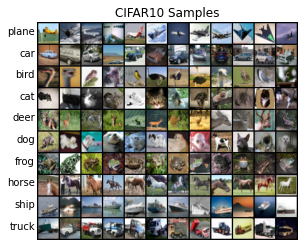

Train data shape:  (50000, 3, 32, 32)
Test data shape:  (10000, 3, 32, 32)


In [6]:
data_dict = utils.preprocess_cifar10(show_examples=True)
# images has been normalized to [0,1]
print('Train data shape: ', data_dict['X_train'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
train_data = data_dict['X_train']
test_data = data_dict['X_test']


In [7]:
print(train_data.shape, train_data.min(), train_data.max())
print(test_data.shape, test_data.min(), test_data.max())

(50000, 3, 32, 32) 0.0 1.0
(10000, 3, 32, 32) 0.0 1.0


## Q1: VAE



In this part, you'll implement a simple VAE model, and use the CIFAR10 dataset to train the model. 

### Loss Function

We'll first take a look at the loss function for the VAE model. As seen below, the loss function for VAEs contains two terms: A reconstruction loss term (left) and a KL divergence term (right). 

$$-E_{z \sim q_{\phi}(z|x)}[log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$$

Note that this is the negative of the variational lower bound shown in the lecture--this ensures that when we are minimizing this loss term, we're maximizing the variational lower bound. The reconstruction loss term can be computed by simply using the binary cross-entropy loss between the original input pixels and the output pixels of our decoder. The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal Gaussian as our prior).

###**Q1.1** 

In practice, we'll use the following losses to optimize the VAE model. **Show that the following terms are equivalent to the reconstruction loss term and KL divergence term.**

- We can optimize the reconstruction loss term $-E_{z\sim q_\phi(z|x)}[\log{p(x|z)}]$
as the MSE loss between original image and reconstructed image. 

- We can optimize the KL divergence term as 

$$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j}$$




**You answer:** 

- For the reconstruction loss $-E_{z\sim q_\phi(z|x)}[\log{p(x|z)}]$, in VAE we assume that $p(x|z) = N(\mu_{x | z}, \sigma_{x|z}^2)$ = $\frac{1}{\sqrt{2\pi}\sigma_{x|z}}e^{-\frac{1}{2}(\frac{x - \mu_{x|z}}{\sigma_{x|z}})^2}$ given that $p(z) = N(0,1), q_{\phi}(z|x) \sim \mathcal{N} $, then we have $-\log p(x|z) = \frac{1}{2\sigma_{x|z}^2}\cdot |x-\mu_{x | z}|^2 + \log (\sqrt{2\pi}\sigma_{x|z})$. Then applying the reparametrization trick, we sample $z$ $L$ times and estimate $-E_{z\sim q_\phi(z|x)}[\log{p(x|z)}] = \frac{1}{L}\sum_{L}-\log p(x|z)$ which can be optimized as the MSE loss between original image $x$ and reconstructed image sampled from $z$.
- For the KL divergence term, we have 
\begin{align*} 
D_{KL}(q_{\phi}(z|x), p(z)) &= \int q_{\phi}(z|x) (\log  q_{\phi}(z|x) - \log p(z)) \\
&= \sum_{j=1}^{J} \int q_{\phi}(z|x)_{j} (\log  q_{\phi}(z|x)_{j} - \log p(z))\\
& = -\sum_{j=1}^{J} \int q_{\phi}(z|x)_{j}( \log\frac{(\sigma_{z|x})_{j} }{\sigma_{p}} + \frac{(x - (\mu_{z|x})_{j})^2}{2(\sigma_{z|x}^2)_{j}} - \frac{(x - \mu_{p})^2}{2\sigma_{p}^2}) \\
&= -\sum_{j=1}^{J} E[\log\frac{(\sigma_{z|x})_{j} }{\sigma_{p}} + \frac{(x - (\mu_{z|x})_{j})^2}{2(\sigma_{z|x}^2)_{j}} - \frac{(x - \mu_{p})^2}{2\sigma_{p}^2}] \\
& = -\sum_{j=1}^{J}\log (\sigma_{z|x})_{j} + \frac{1}{2} - \frac{1}{2}E[x^2] \tag{$p(z) = N(0,1)$}\\
& = -\sum_{j=1}^{J}\log (\sigma_{z|x})_{j} + \frac{1}{2} - \frac{1}{2}(E[(x-(\mu_{z|x})_{j})^2 ] + 2E[x (\mu_{z|x})_{j}] - E[(\mu_{z|x})_{j}^2]) \\
& = -\sum_{j=1}^{J}\log (\sigma_{z|x})_{j} + \frac{1}{2} - \frac{1}{2}((\sigma_{z|x})_{j}^2 + 2(\mu_{z|x})_{j}^2 - (\mu_{z|x})_{j}^2) \\
& = -\frac{1}{2}\sum_{j=1}^{J}1 + \log (\sigma_{z|x})_{j}^2 - (\sigma_{z|x})_{j}^2  - (\mu_{z|x})_{j}^2 \\
\end{align*}

### **Q1.2**

In this question, we'll build a simple VAE model. 

We recommend the following network architecture: 

- Notations:   
  covolutional layer: Conv - \$output_dim - \$kernel_size - \$stride - \$padding  
  transposed covolutional layer: TConv - \$output_dim - \$kernel_size - \$stride - \$padding  
  fully connected layer: fc - \$output_dim

- For encoder model:   
  Conv - 32 - 3 - 1 - 1  
  ReLU   
  Conv - 64 - 3 - 2 - 1  
  ReLU   
  Conv - 128 - 3 - 2 - 1  
  ReLU   
  Conv - 256 - 3 - 2 - 1  
  ReLU  
  flatten to (16, )   
  fc - 32  

- For decoder model:   
  fc - 2048  
  ReLU  
  reshape to (4, 4, 128)  
  TConv - 128 - 4 - 2 - 1  
  ReLU  
  TConv - 64 - 4 - 2 - 1  
  ReLU  
  TConv - 32 - 4 - 2 - 1  
  ReLU  
  Conv - 3 - 3 - 1 - 1


We provide the training code in **models/vae_solver.py** and a model template in **models/vae_model.py**. Please follow the instructions and fill in the functions in **models/vae_model.py**. 

We provide the functions for plotting and visualizing images. **You'll provide the following results.**
- Record the average negative ELBO, reconstruction term, and KL term of the training data (per mini-batch) and testing data (per epoch).
- Sample 100 images using the trained model. 
- Original and reconstructed image pairs using the trained VAE model. 
- Interpolation of 10 image pairs, and show 10 samples for each interpolation. 



In [ ]:
from models.vae_solver import train_vae
from utils.vis import show_samples, plot_vae_training_plot

Epoch 0, loss 87.0252, recon_loss 70.4695, kl_loss 16.5557: 100%|██████████| 50000/50000 [00:10<00:00, 4773.08it/s]
Epoch 1, loss 87.2069, recon_loss 70.4385, kl_loss 16.7684:   2%|▏         | 768/50000 [00:00<00:10, 4851.97it/s]

Test , loss 86.6306, recon_loss 70.2844, kl_loss 16.3462


Epoch 1, loss 80.2665, recon_loss 62.2509, kl_loss 18.0156: 100%|██████████| 50000/50000 [00:10<00:00, 4793.88it/s]
Epoch 2, loss 81.1749, recon_loss 62.7343, kl_loss 18.4406:   2%|▏         | 768/50000 [00:00<00:10, 4859.92it/s]

Test , loss 80.1335, recon_loss 62.5176, kl_loss 17.6160


Epoch 2, loss 78.9769, recon_loss 60.9833, kl_loss 17.9936: 100%|██████████| 50000/50000 [00:10<00:00, 4817.24it/s]
Epoch 3, loss 76.2469, recon_loss 58.4688, kl_loss 17.7781:   2%|▏         | 768/50000 [00:00<00:10, 4565.72it/s]

Test , loss 78.5740, recon_loss 60.4589, kl_loss 18.1151


Epoch 3, loss 78.4443, recon_loss 60.4442, kl_loss 18.0001: 100%|██████████| 50000/50000 [00:10<00:00, 4776.30it/s]
Epoch 4, loss 78.6412, recon_loss 60.6011, kl_loss 18.0401:   2%|▏         | 768/50000 [00:00<00:10, 4764.78it/s]

Test , loss 78.7273, recon_loss 61.4024, kl_loss 17.3249


Epoch 4, loss 78.0660, recon_loss 59.9344, kl_loss 18.1316: 100%|██████████| 50000/50000 [00:10<00:00, 4721.30it/s]
Epoch 5, loss 76.4118, recon_loss 58.2854, kl_loss 18.1264:   2%|▏         | 768/50000 [00:00<00:10, 4909.10it/s]

Test , loss 78.3876, recon_loss 60.3380, kl_loss 18.0496


Epoch 5, loss 77.6755, recon_loss 59.7300, kl_loss 17.9454: 100%|██████████| 50000/50000 [00:10<00:00, 4711.37it/s]
Epoch 6, loss 76.8742, recon_loss 58.7812, kl_loss 18.0930:   2%|▏         | 768/50000 [00:00<00:10, 4559.67it/s]

Test , loss 78.7151, recon_loss 60.5013, kl_loss 18.2138


Epoch 6, loss 77.1594, recon_loss 59.2462, kl_loss 17.9132: 100%|██████████| 50000/50000 [00:10<00:00, 4695.23it/s]
Epoch 7, loss 77.3899, recon_loss 58.8240, kl_loss 18.5659:   2%|▏         | 768/50000 [00:00<00:10, 4734.03it/s]

Test , loss 77.6832, recon_loss 58.9511, kl_loss 18.7320


Epoch 7, loss 77.5107, recon_loss 59.4447, kl_loss 18.0661: 100%|██████████| 50000/50000 [00:10<00:00, 4563.69it/s]
Epoch 8, loss 76.9051, recon_loss 59.2314, kl_loss 17.6737:   2%|▏         | 768/50000 [00:00<00:10, 4666.25it/s]

Test , loss 77.9841, recon_loss 58.5496, kl_loss 19.4345


Epoch 8, loss 77.2329, recon_loss 59.1427, kl_loss 18.0902: 100%|██████████| 50000/50000 [00:10<00:00, 4573.74it/s]
Epoch 9, loss 77.2488, recon_loss 58.6155, kl_loss 18.6333:   2%|▏         | 768/50000 [00:00<00:10, 4544.32it/s]

Test , loss 77.6514, recon_loss 60.5194, kl_loss 17.1320


Epoch 9, loss 76.5291, recon_loss 58.5199, kl_loss 18.0092: 100%|██████████| 50000/50000 [00:10<00:00, 4567.29it/s]
Epoch 10, loss 76.3994, recon_loss 58.1360, kl_loss 18.2634:   2%|▏         | 768/50000 [00:00<00:10, 4643.35it/s]

Test , loss 77.6208, recon_loss 60.1338, kl_loss 17.4870


Epoch 10, loss 76.8822, recon_loss 58.8663, kl_loss 18.0159: 100%|██████████| 50000/50000 [00:10<00:00, 4646.64it/s]
Epoch 11, loss 77.0872, recon_loss 58.6045, kl_loss 18.4827:   2%|▏         | 768/50000 [00:00<00:10, 4623.27it/s]

Test , loss 77.5509, recon_loss 58.8919, kl_loss 18.6590


Epoch 11, loss 76.7906, recon_loss 58.7860, kl_loss 18.0046: 100%|██████████| 50000/50000 [00:10<00:00, 4597.37it/s]
Epoch 12, loss 77.2643, recon_loss 59.3769, kl_loss 17.8874:   2%|▏         | 768/50000 [00:00<00:10, 4719.41it/s]

Test , loss 77.6987, recon_loss 59.9287, kl_loss 17.7700


Epoch 12, loss 76.5910, recon_loss 58.4643, kl_loss 18.1267: 100%|██████████| 50000/50000 [00:10<00:00, 4600.76it/s]
Epoch 13, loss 75.1270, recon_loss 57.2397, kl_loss 17.8874:   2%|▏         | 768/50000 [00:00<00:10, 4692.31it/s]

Test , loss 77.3083, recon_loss 58.8632, kl_loss 18.4452


Epoch 13, loss 77.5633, recon_loss 59.4935, kl_loss 18.0698: 100%|██████████| 50000/50000 [00:10<00:00, 4580.08it/s]
Epoch 14, loss 77.2875, recon_loss 58.6673, kl_loss 18.6202:   1%|▏         | 640/50000 [00:00<00:10, 4554.06it/s]

Test , loss 77.4674, recon_loss 59.3353, kl_loss 18.1321


Epoch 14, loss 76.0712, recon_loss 58.0876, kl_loss 17.9837: 100%|██████████| 50000/50000 [00:10<00:00, 4608.33it/s]
Epoch 15, loss 75.5526, recon_loss 57.7690, kl_loss 17.7836:   1%|▏         | 640/50000 [00:00<00:10, 4548.27it/s]

Test , loss 77.4781, recon_loss 59.4312, kl_loss 18.0469


Epoch 15, loss 76.7117, recon_loss 58.6033, kl_loss 18.1084: 100%|██████████| 50000/50000 [00:11<00:00, 4482.89it/s]
Epoch 16, loss 75.6467, recon_loss 57.5084, kl_loss 18.1383:   1%|▏         | 640/50000 [00:00<00:10, 4527.99it/s]

Test , loss 77.5308, recon_loss 59.7385, kl_loss 17.7923


Epoch 16, loss 76.5792, recon_loss 58.4049, kl_loss 18.1743: 100%|██████████| 50000/50000 [00:11<00:00, 4483.35it/s]
Epoch 17, loss 75.7123, recon_loss 57.5770, kl_loss 18.1353:   2%|▏         | 768/50000 [00:00<00:10, 4709.56it/s]

Test , loss 76.9640, recon_loss 58.4499, kl_loss 18.5141


Epoch 17, loss 75.9902, recon_loss 57.7906, kl_loss 18.1996: 100%|██████████| 50000/50000 [00:11<00:00, 4496.01it/s]
Epoch 18, loss 75.9629, recon_loss 58.0357, kl_loss 17.9273:   2%|▏         | 768/50000 [00:00<00:10, 4579.71it/s]

Test , loss 77.4985, recon_loss 58.6650, kl_loss 18.8335


Epoch 18, loss 75.8816, recon_loss 57.6489, kl_loss 18.2327: 100%|██████████| 50000/50000 [00:11<00:00, 4478.56it/s]
Epoch 19, loss 76.5053, recon_loss 58.0100, kl_loss 18.4953:   2%|▏         | 768/50000 [00:00<00:10, 4630.62it/s]

Test , loss 76.9002, recon_loss 58.4149, kl_loss 18.4853


Epoch 19, loss 76.5333, recon_loss 58.2309, kl_loss 18.3024: 100%|██████████| 50000/50000 [00:11<00:00, 4526.84it/s]


Test , loss 76.9802, recon_loss 58.8619, kl_loss 18.1183
Final negative ELBO: 76.9802, Reconstruction Loss: 58.8619, KL Loss: 18.1183


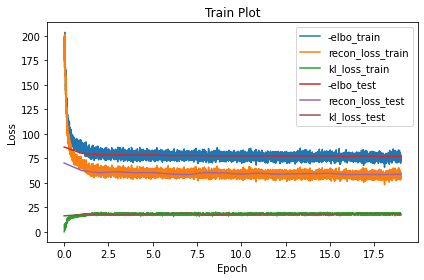

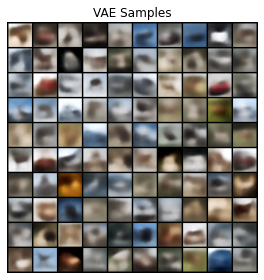

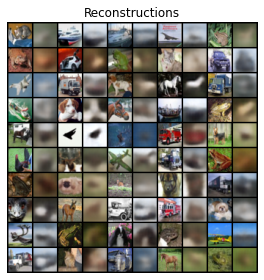

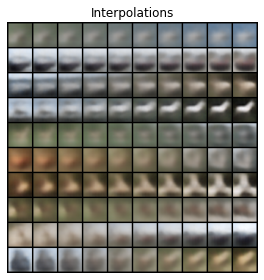

In [ ]:
train_losses, test_losses, samples, reconstructions, interpolations = train_vae(train_data, test_data)
samples, reconstructions, interpolations = samples.astype('float32'), reconstructions.astype('float32'), interpolations.astype('float32')
print(f'Final negative ELBO: {test_losses[-1, 0]:.4f}, Reconstruction Loss: {test_losses[-1, 1]:.4f}, '
      f'KL Loss: {test_losses[-1, 2]:.4f}')
plot_vae_training_plot(train_losses, test_losses, 'Train Plot', 'results/vae_q1_2_train_plot.png')
show_samples(samples, title='VAE Samples', fname='results/vae_q1_2_samples.png')
show_samples(reconstructions, title='Reconstructions', fname='results/vae_q1_2_reconstructions.png')
show_samples(interpolations, title='Interpolations', fname='results/vae_q1_2_interpolations.png')

## Q2: VQ-VAE

In this question, we'll build a simple VQ-VAE model, and train the model using the CIFAR10 dataset. After training VQ-VAE, we'll train a PixelCNN model to learn the prior of categorical latents. You might want to finish *pixel_cnn.ipynb* before completing this part. 

For VQ-VAE model, we'll use the following network architecture:

- Residual_block(dim):   
  batch_norm(dim)  
  ReLU  
  Conv - dim - 3 - 1 - 1  
  batch_norm(dim)  
  ReLU  
  Conv - dim - 1 - 1 - 0

- Encoder:  
  Conv - 256 - 4 - 2 - 1  
  batch_norm(256)  
  ReLU  
  Conv - 256 - 4 - 2 - 1  
  Residual_block(256)  
  Residual_block(256)  

- Decoder:   
  Residual_block(256)  
  Residual_block(256)  
  batch_norm(256)
  ReLU  
  TConv - 256 - 4 - 2 - 1  
  batch_norm(256)  
  ReLU  
  TConv - 3 - 4 - 2 - 1


For PixelCNN model, we'll use the following network architecture:

- Residual_block_pixelcnn(dim):   
  layer_norm(dim)  
  ReLU   
  MaskConv2d-B - dim // 2 - 1 - 1 - 0   
  layer_norm(dim//2)  
  ReLU   
  MaskConv2d-B - dim // 2 - 3 - 1 - 1  
  layer_norm(dim//2)  
  ReLU  
  MaskConv2d-B - dim - 1 - 1 - 0  

- PixelCNN: 
  MaskConv2d-A - 128 - 7 - 1 - 3  
  layer_norm(128)  
  ReLU   
  9 x Residual_block_pixelcnn(128)  
  layer_norm(128)  
  ReLU   
  MaskConv2d-B - 512 - 1 - 1 - 0  
  ReLU   
  MaskConv2d-B - 128 - 1 - 1 - 0  


We provide a training code in **models/vq_vae_solver.py** and a model template in **models/vq_vae_model.py**. Please follow the instructions and fill in the functions in **models/vq_vae_model.py**. 

We provide the functions for plotting and visualizing images. **You'll provide the following results.**
- For the VQ-VAE model, record the loss of the training data (per mini-batch) and testing data (per epoch).
- For the PixelCNN model, record the loss of the training data (per mini-batch) and testing data (per epoch).
- Sample 100 images using the trained model. 
- Show reconstruction image pairs using the trained VQ-VAE model. 


In [8]:
from models.vq_vae_solver import train_vq_vae
from utils.vis import show_samples, save_training_plot

Epoch 0, loss 290.9753, recon_loss 0.4040, reg_loss 290.5713:   6%|▌         | 2816/50000 [32:00<8:56:13,  1.47it/s]
Epoch 0, loss 0.1196, recon_loss 0.0349, reg_loss 0.0847: 100%|██████████| 50000/50000 [00:28<00:00, 1756.77it/s]
Epoch 1, loss 0.1327, recon_loss 0.0361, reg_loss 0.0967:   1%|          | 256/50000 [00:00<00:28, 1742.84it/s]

Test , loss 0.1369, recon_loss 0.0352, reg_loss 0.1017


Epoch 1, loss 0.0778, recon_loss 0.0295, reg_loss 0.0483: 100%|██████████| 50000/50000 [00:28<00:00, 1737.70it/s]
Epoch 2, loss 0.0758, recon_loss 0.0284, reg_loss 0.0474:   1%|          | 256/50000 [00:00<00:28, 1717.66it/s]

Test , loss 0.0746, recon_loss 0.0278, reg_loss 0.0468


Epoch 2, loss 0.0657, recon_loss 0.0265, reg_loss 0.0392: 100%|██████████| 50000/50000 [00:29<00:00, 1711.00it/s]
Epoch 3, loss 0.0656, recon_loss 0.0258, reg_loss 0.0398:   1%|          | 256/50000 [00:00<00:29, 1696.44it/s]

Test , loss 0.0670, recon_loss 0.0263, reg_loss 0.0408


Epoch 3, loss 0.0612, recon_loss 0.0255, reg_loss 0.0358: 100%|██████████| 50000/50000 [00:29<00:00, 1683.44it/s]
Epoch 4, loss 0.0593, recon_loss 0.0248, reg_loss 0.0346:   1%|          | 256/50000 [00:00<00:29, 1662.84it/s]

Test , loss 0.0598, recon_loss 0.0244, reg_loss 0.0354


Epoch 4, loss 0.0625, recon_loss 0.0254, reg_loss 0.0372: 100%|██████████| 50000/50000 [00:29<00:00, 1672.92it/s]
Epoch 5, loss 0.0640, recon_loss 0.0253, reg_loss 0.0387:   1%|          | 256/50000 [00:00<00:30, 1652.09it/s]

Test , loss 0.0605, recon_loss 0.0245, reg_loss 0.0360


Epoch 5, loss 0.0569, recon_loss 0.0244, reg_loss 0.0326: 100%|██████████| 50000/50000 [00:29<00:00, 1674.62it/s]
Epoch 6, loss 0.0546, recon_loss 0.0226, reg_loss 0.0320:   1%|          | 256/50000 [00:00<00:29, 1680.75it/s]

Test , loss 0.0561, recon_loss 0.0237, reg_loss 0.0323


Epoch 6, loss 0.0564, recon_loss 0.0245, reg_loss 0.0318: 100%|██████████| 50000/50000 [00:29<00:00, 1675.37it/s]
Epoch 7, loss 0.0566, recon_loss 0.0244, reg_loss 0.0322:   1%|          | 256/50000 [00:00<00:30, 1619.85it/s]

Test , loss 0.0552, recon_loss 0.0236, reg_loss 0.0316


Epoch 7, loss 0.0640, recon_loss 0.0245, reg_loss 0.0395: 100%|██████████| 50000/50000 [00:29<00:00, 1672.47it/s]
Epoch 8, loss 0.0645, recon_loss 0.0246, reg_loss 0.0399:   1%|          | 256/50000 [00:00<00:29, 1663.84it/s]

Test , loss 0.0654, recon_loss 0.0255, reg_loss 0.0399


Epoch 8, loss 0.0542, recon_loss 0.0235, reg_loss 0.0307: 100%|██████████| 50000/50000 [00:29<00:00, 1672.06it/s]
Epoch 9, loss 0.0558, recon_loss 0.0235, reg_loss 0.0323:   1%|          | 256/50000 [00:00<00:29, 1683.85it/s]

Test , loss 0.0547, recon_loss 0.0228, reg_loss 0.0320


Epoch 9, loss 0.0547, recon_loss 0.0249, reg_loss 0.0298: 100%|██████████| 50000/50000 [00:30<00:00, 1662.00it/s]
Epoch 10, loss 0.0514, recon_loss 0.0238, reg_loss 0.0276:   1%|          | 256/50000 [00:00<00:29, 1684.14it/s]

Test , loss 0.0516, recon_loss 0.0235, reg_loss 0.0281


Epoch 10, loss 0.0513, recon_loss 0.0234, reg_loss 0.0279: 100%|██████████| 50000/50000 [00:29<00:00, 1680.37it/s]
Epoch 11, loss 0.0560, recon_loss 0.0248, reg_loss 0.0312:   1%|          | 256/50000 [00:00<00:30, 1633.22it/s]

Test , loss 0.0534, recon_loss 0.0226, reg_loss 0.0308


Epoch 11, loss 0.0492, recon_loss 0.0228, reg_loss 0.0264: 100%|██████████| 50000/50000 [00:29<00:00, 1675.53it/s]
Epoch 12, loss 0.0511, recon_loss 0.0238, reg_loss 0.0273:   1%|          | 256/50000 [00:00<00:29, 1693.08it/s]

Test , loss 0.0489, recon_loss 0.0221, reg_loss 0.0268


Epoch 12, loss 0.0485, recon_loss 0.0225, reg_loss 0.0260: 100%|██████████| 50000/50000 [00:29<00:00, 1677.44it/s]
Epoch 13, loss 0.0494, recon_loss 0.0221, reg_loss 0.0273:   1%|          | 256/50000 [00:00<00:29, 1684.86it/s]

Test , loss 0.0481, recon_loss 0.0221, reg_loss 0.0260


Epoch 13, loss 0.0493, recon_loss 0.0229, reg_loss 0.0263: 100%|██████████| 50000/50000 [00:29<00:00, 1676.25it/s]
Epoch 14, loss 0.1111, recon_loss 0.0267, reg_loss 0.0844:   1%|          | 256/50000 [00:00<00:29, 1660.58it/s]

Test , loss 0.0883, recon_loss 0.0264, reg_loss 0.0619


Epoch 14, loss 0.0473, recon_loss 0.0221, reg_loss 0.0252: 100%|██████████| 50000/50000 [00:29<00:00, 1667.38it/s]
Epoch 15, loss 0.0467, recon_loss 0.0212, reg_loss 0.0254:   1%|          | 256/50000 [00:00<00:30, 1646.66it/s]

Test , loss 0.0472, recon_loss 0.0217, reg_loss 0.0255


Epoch 15, loss 0.0468, recon_loss 0.0220, reg_loss 0.0248: 100%|██████████| 50000/50000 [00:30<00:00, 1660.10it/s]
Epoch 16, loss 0.0473, recon_loss 0.0213, reg_loss 0.0260:   1%|          | 256/50000 [00:00<00:30, 1646.34it/s]

Test , loss 0.0467, recon_loss 0.0218, reg_loss 0.0249


Epoch 16, loss 0.0474, recon_loss 0.0223, reg_loss 0.0251: 100%|██████████| 50000/50000 [00:29<00:00, 1671.69it/s]
Epoch 17, loss 0.0465, recon_loss 0.0214, reg_loss 0.0250:   1%|          | 256/50000 [00:00<00:30, 1657.64it/s]

Test , loss 0.0469, recon_loss 0.0220, reg_loss 0.0249


Epoch 17, loss 0.0464, recon_loss 0.0219, reg_loss 0.0246: 100%|██████████| 50000/50000 [00:29<00:00, 1671.08it/s]
Epoch 18, loss 0.0491, recon_loss 0.0236, reg_loss 0.0255:   1%|          | 256/50000 [00:00<00:30, 1658.00it/s]

Test , loss 0.0459, recon_loss 0.0215, reg_loss 0.0244


Epoch 18, loss 0.0471, recon_loss 0.0223, reg_loss 0.0248: 100%|██████████| 50000/50000 [00:29<00:00, 1673.17it/s]
Epoch 19, loss 0.0450, recon_loss 0.0209, reg_loss 0.0241:   1%|          | 256/50000 [00:00<00:29, 1666.94it/s]

Test , loss 0.0463, recon_loss 0.0217, reg_loss 0.0246


Epoch 19, loss 0.0460, recon_loss 0.0232, reg_loss 0.0228: 100%|██████████| 50000/50000 [00:29<00:00, 1674.66it/s]


Test , loss 0.0452, recon_loss 0.0221, reg_loss 0.0231


Epoch 1, loss 2.8575:   1%|          | 256/50000 [00:00<00:24, 2017.23it/s]

Test , loss 2.8953


Epoch 2, loss 2.8030:   1%|          | 256/50000 [00:00<00:24, 2009.42it/s]

Test , loss 2.8594


Epoch 3, loss 2.7959:   1%|          | 256/50000 [00:00<00:24, 2052.54it/s]

Test , loss 2.8392


Epoch 4, loss 2.7489:   1%|          | 256/50000 [00:00<00:25, 1981.70it/s]

Test , loss 2.8313


Epoch 5, loss 2.7539:   1%|          | 256/50000 [00:00<00:24, 2024.78it/s]

Test , loss 2.8275


Epoch 6, loss 2.8064:   1%|          | 256/50000 [00:00<00:24, 2066.21it/s]

Test , loss 2.8201


Epoch 7, loss 2.7521:   1%|          | 256/50000 [00:00<00:24, 2023.00it/s]

Test , loss 2.8177


Epoch 8, loss 2.7369:   1%|          | 256/50000 [00:00<00:24, 2031.95it/s]

Test , loss 2.8160


Epoch 9, loss 2.7837:   1%|          | 256/50000 [00:00<00:24, 2070.99it/s]

Test , loss 2.8167


Epoch 10, loss 2.7074:   1%|          | 256/50000 [00:00<00:24, 2022.06it/s]

Test , loss 2.8191


Epoch 11, loss 2.6810:   1%|          | 256/50000 [00:00<00:24, 2042.87it/s]

Test , loss 2.8172


Epoch 12, loss 2.7037:   1%|          | 256/50000 [00:00<00:24, 2029.36it/s]

Test , loss 2.8255


Epoch 13, loss 2.7140:   1%|          | 256/50000 [00:00<00:23, 2102.47it/s]

Test , loss 2.8237


Epoch 14, loss 2.7317:   1%|          | 256/50000 [00:00<00:24, 2067.03it/s]

Test , loss 2.8244


Epoch 14, loss 2.7267: 100%|██████████| 50000/50000 [00:24<00:00, 2071.83it/s]


Test , loss 2.8270
1.0
0.0
0.4575443
1.0
0.018887162
0.45901224

VQ-VAE Final Test Loss: 0.0452
PixelCNN Prior Final Test Loss: 2.8270


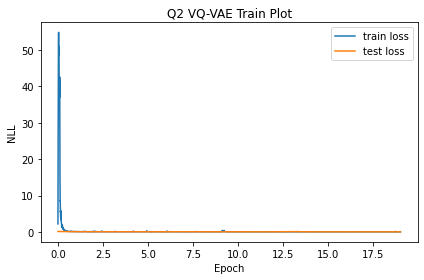

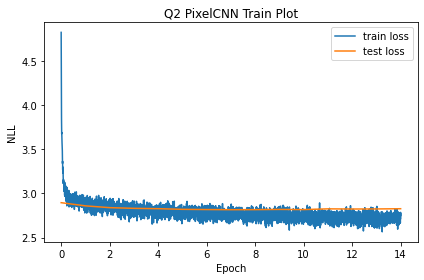

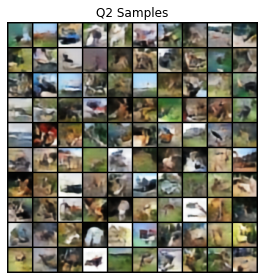

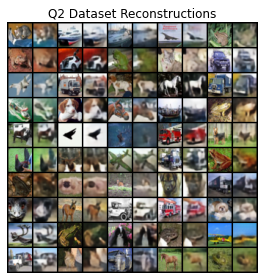

In [39]:
vqvae_train_losses, vqvae_test_losses, pixelcnn_train_losses, pixelcnn_test_losses, samples, reconstructions = train_vq_vae(train_data, test_data)
samples, reconstructions = samples.astype('float32'), reconstructions.astype('float32')
print(f'VQ-VAE Final Test Loss: {vqvae_test_losses[-1]:.4f}')
print(f'PixelCNN Prior Final Test Loss: {pixelcnn_test_losses[-1]:.4f}')

save_training_plot(vqvae_train_losses, vqvae_test_losses,'Q2 VQ-VAE Train Plot',
                    'results/q2_vqvae_train_plot.png')
save_training_plot(pixelcnn_train_losses, pixelcnn_test_losses,'Q2 PixelCNN Train Plot',
                    'results/q2_vqvae_pixelcnn_train_plot.png')
show_samples(samples.transpose(0, 3, 1, 2), title='Q2 Samples',
              fname='results/q2_vqvae_samples.png')
show_samples(reconstructions.transpose(0, 3, 1, 2), title='Q2 Dataset Reconstructions',
              fname='results/q2_vqvae_reconstructions.png')


In [38]:
from tqdm import tqdm
tqdm._instances.clear()